In [1]:
import keras
keras.__version__

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
import os 
import shutil
import nibabel as nib
import numpy as np
import pandas as pd 
from keras.models import load_model
from nilearn import image as nlimg
from keras import backend as K

In [3]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.AveragePooling3D(pool_size=(3, 3, 3), strides=None, padding='valid',
                         input_shape=(192, 192, 160,1),data_format='channels_last'))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling3d_1 (Average (None, 64, 64, 53, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 53, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 26, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 30, 24, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 15, 15, 12, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 13, 13, 10, 128)   221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 5, 128)      0         
__________

In [5]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [6]:
model.load_weights('CN_and_AD_3D_checkpoint.h5')

In [7]:
target_shape = [192,192,160]
target_affine = np.array([ [ 4.29048360e-08,  3.24291396e-04, -1.20006235e+00, 9.47253036e+01],
                            [-3.27969076e-04, -1.23945871e+00, -3.13983739e-04, 1.38530121e+02],
                            [-1.25348123e+00,  3.24300145e-04,  4.10763858e-08, 1.08530121e+02],
                            [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]
                    ])

NIfTI_img = nib.load('D:\\mri\\Test_AD.nii')
#NIfTI_img = nib.load('D:\\mri\\Test_CN.nii')
img = nlimg.resample_img(NIfTI_img, target_affine=target_affine, target_shape=target_shape, interpolation='continuous', copy=True, order='F', clip=True)
img_data = img.get_data()
X = np.empty((1,192, 192, 160, 1))
#X[0,] = img_data
X[0,] = np.expand_dims(img_data, axis=4)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [8]:
print(X.shape)

(1, 192, 192, 160, 1)


In [9]:
# La primera probabilidad corresponde a que el paciente no tenga Alzheimer
# La segunda probabilidad corresponde a que el paciente tenga Alzheimer
preds = model.predict(X)
print(preds)
print(preds.shape)

[[0.5972774 0.842023 ]]
(1, 2)


In [10]:
np.argmax(preds[0])

1

In [11]:
alzheimer_output = model.output[:, 1]
print(model.output)
last_conv_layer = model.get_layer(index=7)
#last_conv_layer = model.get_layer('conv3d_4')
grads = K.gradients(alzheimer_output, last_conv_layer.output)[0] 
print(grads)
pooled_grads = K.mean(grads, axis=(0,1,2,3))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X])
for i in range(128):
    conv_layer_output_value[:,:,:, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap.shape)

Tensor("dense_2/Sigmoid:0", shape=(?, 2), dtype=float32)
Tensor("gradients/max_pooling3d_4/MaxPool3D_grad/MaxPool3DGrad:0", shape=(?, 4, 4, 3, 128), dtype=float32)
(4, 4, 3)


In [12]:
print(grads.shape)
print(pooled_grads.shape)

(?, 4, 4, 3, 128)
(128,)


In [13]:
import matplotlib.pyplot as plt
heatmap = heatmap[:,:,1]

(4, 4)


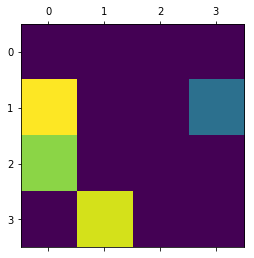

In [14]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
print(heatmap.shape)

(192, 192)
(192, 192, 3)


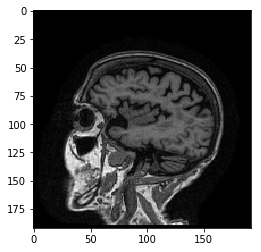

In [15]:
import cv2
img = img_data[:,:,53]
print(img.shape)
plt.imshow(img,cmap=plt.cm.gray)
plt.imsave('red_alzheimer.jpg',img,cmap=plt.cm.gray)

img = cv2.imread('red_alzheimer.jpg')
print(img.shape)

(192, 192)
(192, 192)
(192, 192, 3)


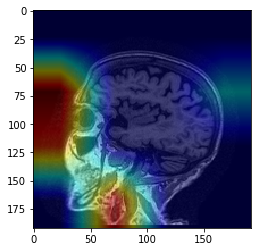

In [16]:
heatmap1 = heatmap
heatmap1 = np.maximum(heatmap1,0)
heatmap1 /= np.max(heatmap)
heatmap1 = cv2.resize(1-heatmap,(img.shape[1], img.shape[0]))
print(heatmap1.shape)
heatmap1 = np.uint8(255 * heatmap1)
print(heatmap1.shape)
heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
print(heatmap1.shape)
superimposed_img = heatmap1 * 0.4 + img * .6

plt.imshow(superimposed_img.astype(np.uint8))
plt.imsave('heatmap.jpg', superimposed_img.astype(np.uint8))